In [1]:
%matplotlib notebook
import orbipy as op
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from copy import copy
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

In [123]:
model = op.crtbp3_model()
precise_model = op.crtbp3_model()
precise_model.integrator.set_params(max_step=np.pi/180)
stm_model = op.crtbp3_model(stm=True)

In [3]:
plotter = op.plotter.from_model(model, length_units='nd', velocity_units='nd/nd')
scaler = plotter.scaler

In [4]:
class Hyperbolic:
    def __init__(self):
        self.c2 = self.calc_c2()
        self.lam = self.calc_lam()
        self.omega = self.calc_omega()
        self.k1 = self.calc_k1()
        self.k2 = self.calc_k2()
        self.k3 = self.calc_k3()
        self.k4 = self.calc_k4()
        
    def p1(self, state):
        (x, y) = state[:2]
        x -= model.L1
        (vx, vy) = state[3:5]
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) +\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def p1_table(self, orbit):
        x = orbit['x'].values - model.L1
        vx = orbit['vx'].values
        y = orbit['y'].values
        vy = orbit['vy'].values
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) +\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def p2_table(self, orbit):
        x = orbit['x'].values - model.L1
        vx = orbit['vx'].values
        y = orbit['y'].values
        vy = orbit['vy'].values
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) -\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def p2(self, state):
        (x, y) = state[:2]
        x -= model.L1
        (vx, vy) = state[3:5]
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) -\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def calc_vy(self, state):
        (x, y) = state[:2]
        x -= model.L1
        (vx, vy) = state[3:5]
        
        return (self.k3*self.omega*x+(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega)*(self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/self.k1
        
    def calc_c2(self):
        r1 = np.abs(model.L1+model.mu)
        r2 = np.abs(model.L1+model.mu-1)
        
        return (1.-model.mu)/r1**3+model.mu/r2**3
    
    def calc_lam(self):
        return np.sqrt((self.c2-2+np.sqrt(9*self.c2**2-8*self.c2))/2)
    
    def calc_omega(self):
        return np.sqrt((-1.*self.c2+2+np.sqrt(9*self.c2**2-8*self.c2))/2)
        
    def calc_k1(self):
        return -2/(self.c2+3+self.lam**2)
    
    def calc_k2(self):
        return -2/(2*self.c2+1-self.lam**2)
    
    def calc_k3(self):
        return (self.omega*(self.c2-1+self.lam**2))/((self.c2-1)*(self.c2+3+self.lam**2))
    
    def calc_k4(self):
        return (self.lam*(-2*self.c2+3+self.lam**2))/((self.c2-1)*(-2*self.c2-1+self.lam**2))

In [5]:
def interactive_map(data, buffer):
    def onclick(event):
        if event.button == 3:
            ix, iy = event.xdata, event.ydata
            buffer.append([ix, iy])
            ax.plot(ix, iy, 'or')
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(data['x0'], data['z0'], 'ob')
    ax.axis('equal')
    cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [7]:
with open('amp.pkl', 'rb') as fp:
    applicability = pickle.load(fp)

# Запустите ячейку и выберите начальную точку левой кнопкой мыши, выключите график

<IPython.core.display.Javascript object>


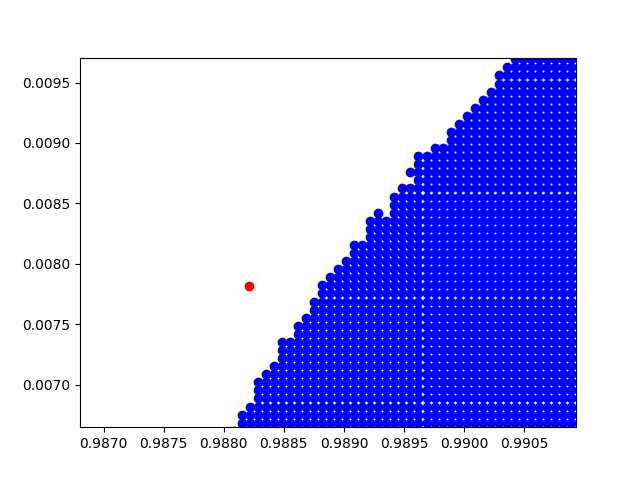

In [8]:
buffer = []
interactive_map(applicability, buffer)

In [9]:
x0 = buffer[-1][0]
z0 = buffer[-1][1]
dx = scaler(-1000, 'km-nd')

In [10]:
x0

0.9882093550163036

In [11]:
z0

0.00781500226599873

In [12]:
EL1_dist = 1.-model.mu - model.L1
left = op.eventX(model.L1-EL1_dist)
right = op.eventX(1.-model.mu)

first_corr = op.border_correction(model, op.x_direction(), [left], [right])
corr = op.border_correction(model, op.y_direction(), [left], [right])
# corr = op.border_correction(model, op.unstable_direction_stm(stm_model), [left], [right])
sk = op.simple_station_keeping(precise_model, first_corr, corr, rev=np.pi/2)

In [51]:
large_orbs = pickle.load(open('../large_orbs_examples.bin','rb'))

In [13]:
s0 = model.get_zero_state()
s0[0] = x0
s0[2] = z0

In [224]:
orb1 = sk.prop(0.0, s0, N=2)

Simple station-keeping: 0 1 


In [174]:
sk.dvout

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.02485629, 0.        ]])

In [175]:
orb1.shape

(91, 7)

In [157]:
orb = large_orbs[-1]

<IPython.core.display.Javascript object>


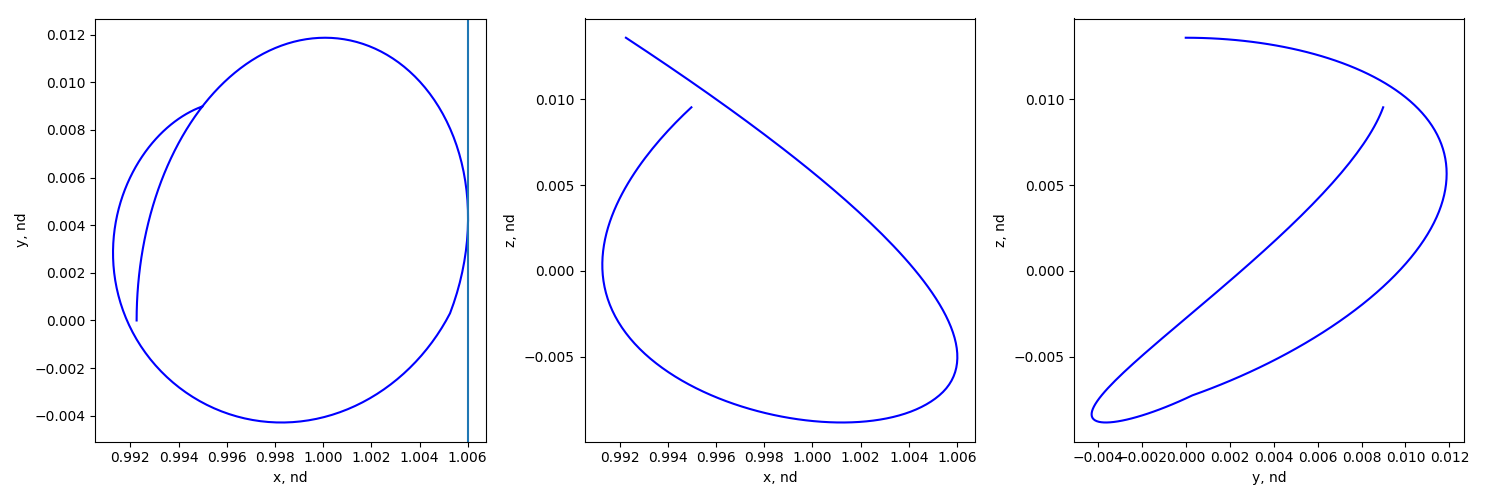

In [225]:
ax = plotter.plot_proj(orb1)
ax[0].axvline(right.value)

In [142]:
sk.arr[7][-1]

array([ 2.51152879e+01,  9.94653216e-01,  1.71635014e-03,  1.37697979e-02,
       -9.67464708e-05,  5.62643213e-03, -8.36710723e-03])

<IPython.core.display.Javascript object>


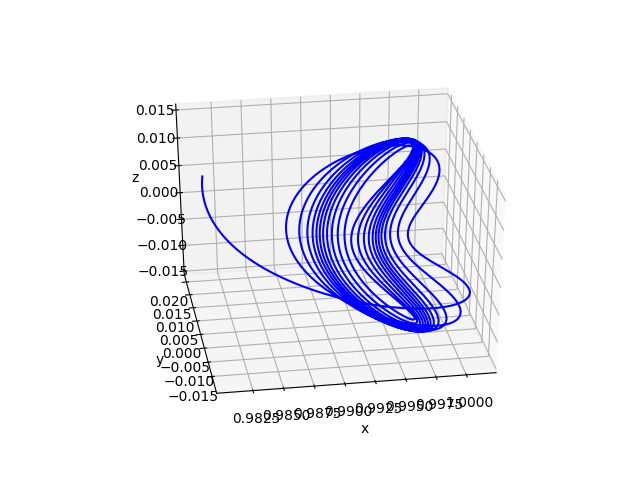

Text(0.5, 0, 'z')

In [43]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(orb1['x'], orb1['y'], orb1['z'], c='b')
    
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [128]:
# s0_target = orb1.iloc[-500][1:].values
s0_target = sk.arr[7][-1][1:]

In [129]:
s0_target

array([ 9.94653215e-01,  1.71634417e-03,  1.37698004e-02, -9.67501444e-05,
        5.62643576e-03, -8.36710002e-03])

In [16]:
def generate_traj(s0, dv=1e-5, num=50, dt = 10*np.pi):
    vy = s0[4]
#     print('vy: {}'.format(vy))
    vs_lower = np.linspace(vy-dv,vy, num)[:-1]
#     print('vs_lower[0]: {}'.format(vs_lower[0]))
    vs_upper = np.linspace(vy, vy+dv, num)[1:]
    traj_lower = []
    traj_upper = []
    
    for v in vs_lower:
        s1 = s0.copy()
        s1[4] = v
#         print(s1[3:])
        df = model.prop(s1, 0.0, dt)
        traj_lower.append(df)
        
    for v in vs_upper:
        s1 = s0.copy()
        s1[4] = v
        df = model.prop(s1, 0.0, dt)
        traj_upper.append(df)
    
    return traj_lower, traj_upper

In [146]:
# def generate_traj_new(s0, dv=1e-5, num=50, dt=10*np.pi):
#     v_target = np.linalg.norm(s0[3:])
#     print('v_target: {}'.format(v_target))
#     vs_lower = np.linspace(v_target-dv,v_target, num)[:-1]
#     print('vs_lower[0]: {}'.format(vs_lower[0]))
#     vs_upper = np.linspace(v_target, v_target+dv, num)[1:]
#     traj_lower = []
#     traj_upper = []
    
#     for v in vs_lower:
#         s1 = s0.copy()
#         s1[3:] = v*s0[3:]/v_target
#         print(s1[3:])
#         df = model.prop(s1, 0.0, dt)
#         traj_lower.append(df)
        
#     for v in vs_upper:
#         s1 = s0.copy()
#         s1[3:] = v*s0[3:]/v_target
#         df = model.prop(s1, 0.0, dt)
#         traj_upper.append(df)
    
#     return traj_lower, traj_upper

In [143]:
traj_lower, traj_upper = generate_traj(s0_target, dv=1e-3, dt=4*np.pi)

<IPython.core.display.Javascript object>


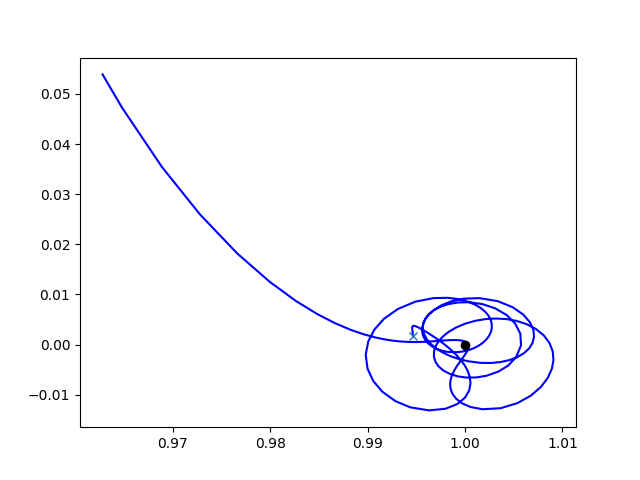

In [153]:
# plt.plot(orb1['x'], orb1['y'],'k')
# for orb in traj_lower:
#     plt.plot(orb['x'], orb['y'],'b')  

# for orb in traj_upper:
#     plt.plot(orb['x'], orb['y'],'r', alpha=0.5)

plt.plot(traj_lower[4]['x'], traj_lower[4]['y'],'b')
# plt.plot(traj_upper[0]['x'], traj_upper[0]['y'],'r')

plt.plot(s0_target[0], s0_target[1], 'x')
plt.plot(1.-model.mu, 0, 'ko')

In [125]:
def energy(s0, v):
    s1 = s0.copy()
#     s1[3:] = v*s1[3:]/np.linalg.norm(s1[3:])
    s1[4] = v
    df = model.prop(s1, 0.0, 4*np.pi)
    ax = plotter.plot_proj(df)
    ax[0].plot(1.-model.mu, 0, 'ok')
#     ax[0].axvline(right.value)
#     ax[0].axvline(left.value)

In [21]:
s0

array([0.98820936, 0.        , 0.007815  , 0.        , 0.        ,
       0.        ])

In [ ]:
(0.02+0.03)/2+0.00052

<IPython.core.display.Javascript object>


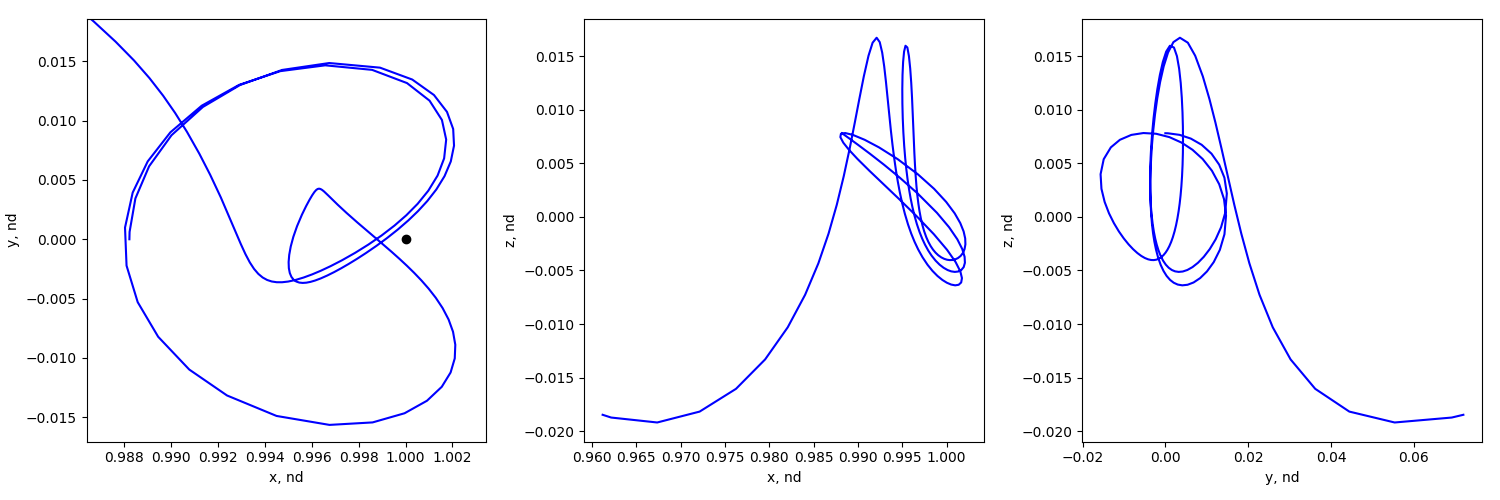

In [126]:
energy(s0, (0.02+0.03)/2+0.000524)

<IPython.core.display.Javascript object>


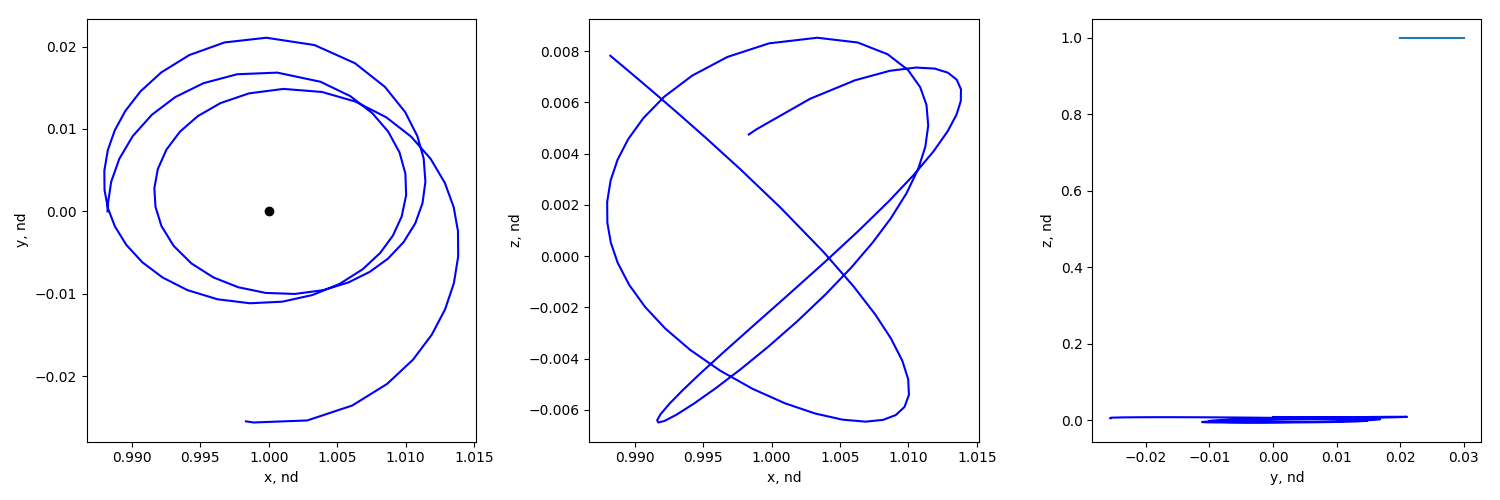

In [70]:
energy(s0, 0.03)

In [248]:
det = op.event_detector(model, events = [left, right])

In [249]:
df, ev = det.prop(s0,0.0,10.0)

In [250]:
ev

,e,cnt,trm,t,x,y,z,vx,vy,vz
0,0.0,-1.0,1.0,1.388483,0.980061,0.011244,-0.00488,-0.015838,0.021642,-0.018338


In [254]:
corr.calc_dv(0.0, s0)

array([0.       , 0.       , 0.       , 0.       , 0.0166507, 0.       ])

In [82]:
class EventYCondXG(op.eventY):
    def __init__(self, cond_value, *args, **kwargs):
        self.cond_value = copy(cond_value)
        super().__init__(*args, **kwargs)
        
    def __call__(self, t, s):
        if s[0] > self.cond_value:
            return s[1] - self.value
        else:
            return self.value + 10

In [135]:
def final_pos(s0, v_range):
    ileft = op.eventX(model.L1-EL1_dist-scaler(50000,'km-nd'))
#     iright = op.eventX(1.-model.mu)
    iright = EventYCondXG(cond_value=1.-model.mu, value = 0)
    es = []
    det = op.event_detector(model, events = [ileft, iright])
    for v in v_range:
        s1 = s0.copy()
        s1[4] = v
        df, ev = det.prop(s1, 0.0, 10*np.pi)
        es.append(ev['e'])
#     icorr = op.border_correction(model, op.x_direction(), [ileft], [iright])
#     expected = icorr.calc_dv(0.0, s0)[3]
    plt.plot(v_range, es)
#     plt.plot(v_range, es,'.')
    plt.axvline(v0,c='r')

<IPython.core.display.Javascript object>


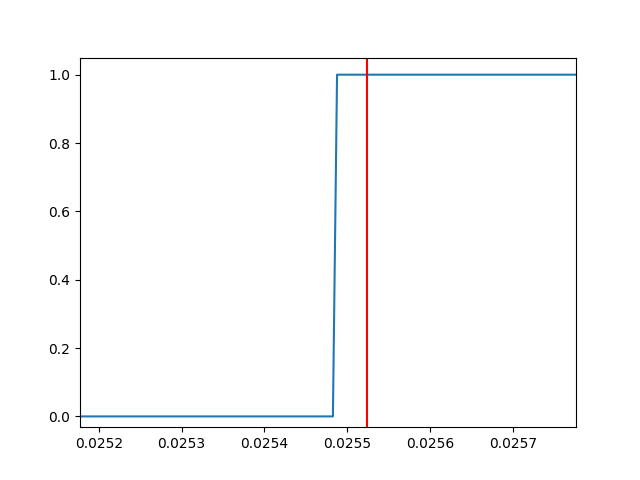

In [136]:
v0 = (0.02+0.03)/2+0.000524
final_pos(s0, np.linspace(0.02,0.03,2000))
# final_pos(s0, [v0])

In [114]:
ileft = op.eventX(model.L1-EL1_dist-scaler(50000,'km-nd'))
iright = EventYCondXG(cond_value=1.-model.mu, value = 0)
icorr = op.border_correction(model, op.y_direction(), [ileft], [iright])

In [137]:
det = op.event_detector(model, events = [ileft, iright])

<IPython.core.display.Javascript object>


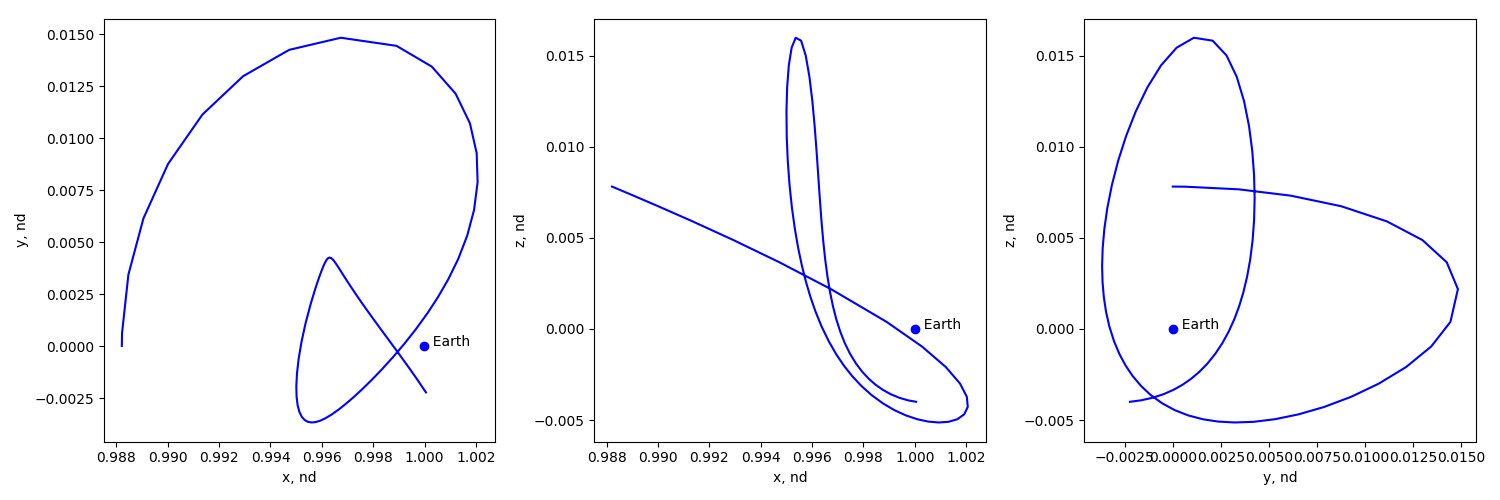

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4bbc1115f8>,
      dtype=object)

In [142]:
s3 = s0.copy()
s3[4] = v0
df, ev = det.prop(s3 ,0.0, 12)
ax = plotter.plot_proj(df)
plotter.plot_proj(ax=ax, plottables=[plotter.m], marker='o')

In [143]:
s0

array([0.98820936, 0.        , 0.007815  , 0.        , 0.        ,
       0.        ])

In [144]:
pickle.dump(s0, open('init_coord.bin','wb'))

In [115]:
s2 = s0.copy()
s2[4] = 0.0251

In [116]:
s1 = s2 + icorr.calc_dv(0.0,s2)

<IPython.core.display.Javascript object>


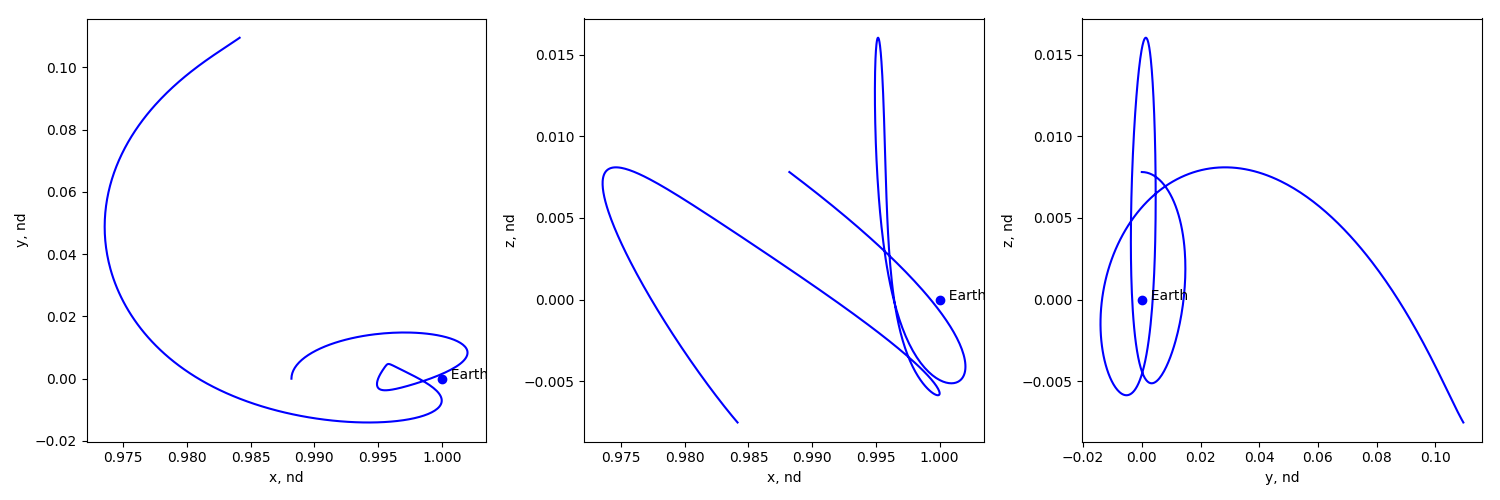

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4bbc40b630>,
      dtype=object)

In [117]:
df = precise_model.prop(s1, 0.0, 3*np.pi)
ax = plotter.plot_proj(df)
plotter.plot_proj(ax=ax, plottables=[plotter.m], marker='o')

In [304]:
js = [model.jacobi(s[1:]) for s in df.values]

In [305]:
np.std(js)

7.132238993960515e-16

In [218]:
traj_lower[-1].iloc[0]['vy']

-0.01331469313847949

In [220]:
s0_target[4]

-0.01331265232215296

In [219]:
traj_upper[0].iloc[0]['vy']

-0.01331061150582643

In [322]:
upper_xpy = traj_upper[0]['x'] + traj_upper[0]['y']

lower_xpy = traj_lower[-1]['x'] + traj_lower[-1]['y']

middle_xpy = orb1.iloc[-500:-1]['x'] + orb1.iloc[-500:-1]['y']

upper_xmy = traj_upper[0]['x'] - traj_upper[0]['y']

lower_xmy = traj_lower[-1]['x'] - traj_lower[-1]['y']

middle_xmy = orb1.iloc[-500:-1]['x'] - orb1.iloc[-500:-1]['y']

<IPython.core.display.Javascript object>


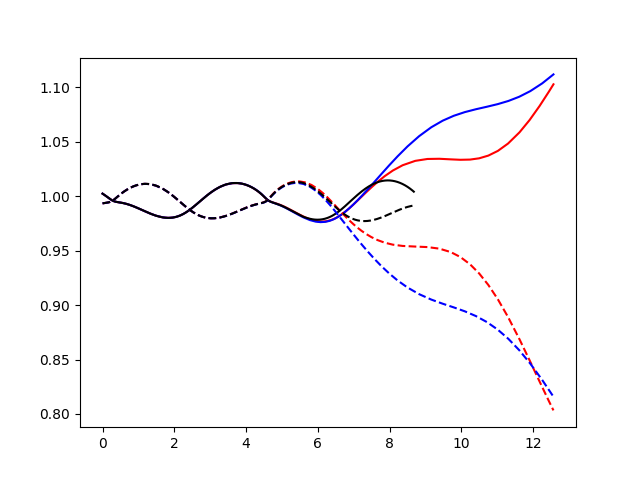

In [323]:
plt.plot(traj_upper[0]['t'], upper_xpy, 'r')
plt.plot(traj_lower[-1]['t'], lower_xpy, 'b')
plt.plot(orb1.iloc[-500:-1]['t']-orb1.iloc[-500]['t'], middle_xpy, 'k')

plt.plot(traj_upper[0]['t'], upper_xmy, '--r')
plt.plot(traj_lower[-1]['t'], lower_xmy, '--b')
plt.plot(orb1.iloc[-500:-1]['t']-orb1.iloc[-500]['t'], middle_xmy, '--k')

In [272]:
class EventXpY(op.base_event):
    def __call__(self, t, s):
        return (s[0]+s[1]) - self.value

In [340]:
class EventXCondG(op.base_event):
    def __init__(self, cond_value, *args, **kwargs):
        self.cond_value = copy(cond_value)
        super().__init__(*args, **kwargs)
        
    def __cal__(self, t, s):
        if s[0] > self.cond_value:
            return s[0] - self.value
        else:
            return value + 10

In [341]:
class EventYCondL(op.base_event):
    def __init__(self, cond_value, *args, **kwargs):
        self.cond_value = copy(cond_value)
        super().__init__(*args, **kwargs)
        
    def __cal__(self, t, s):
        if s[1] < self.cond_value:
            return s[1] - self.value
        else:
            return value + 10

In [342]:
ev1 = EventXpY(value=1.02, terminal=True)
ev2 = EventXpY(value=0.97, terminal=True)

In [330]:
lev1 = op.eventX(1.-model.mu, direction=1)
lev2 = op.eventY(0, direction=-1)
# lev2 = EventYCondL(cond_value)
lev3 = op.eventX(1.-model.mu, direction=-1)
lev4 = op.eventY(0, direction=1)
loop_ev = op.event_chain([lev1,lev2,lev3,lev4])

In [350]:
cx = op.eventConeX(center = np.array([0.999072,0,0]), value = np.radians(25))

In [304]:
def calc_time_inside_range(s0, events, dv=1e-5, num=100):
    vy = s0[4]
    vs = np.linspace(vy-dv, vy+dv, num)
    ts = []
    det = op.event_detector(model, events = events)
    s1 = s0.copy()
    for v in vs:
        s1 = s0.copy()
        s1[4] = v
        try:
            df, ev = det.prop(s1, 0.0, 30*np.pi)
            ts.append(ev.iloc[0]['t'])
        except Exception as e:
            print(v)
    return vs, ts

In [305]:
def calc_time_inside(s0, events):
    det = op.event_detector(model, events = events)
    df, ev = det.prop(s0, 0.0, 30*np.pi)
    return ev.iloc[0]['t']

In [327]:
vs, ts = calc_time_inside_range(s0_target, [ev1, ev2], dv=1e-5)

In [306]:
temp = calc_time_inside(s0_target, [ev1, ev2])

In [307]:
temp

7.830617934460888

<IPython.core.display.Javascript object>


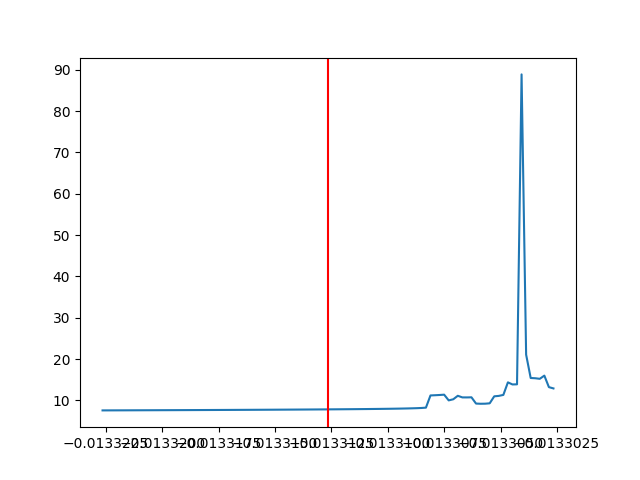

In [328]:
plt.plot(vs, ts)
plt.axvline(s0_target[4], c='r')

In [331]:
s1 = s0_target.copy()
s1[4] = vs[np.argmax(ts)]
df = model.prop(s1, 0.0, 90)

<IPython.core.display.Javascript object>


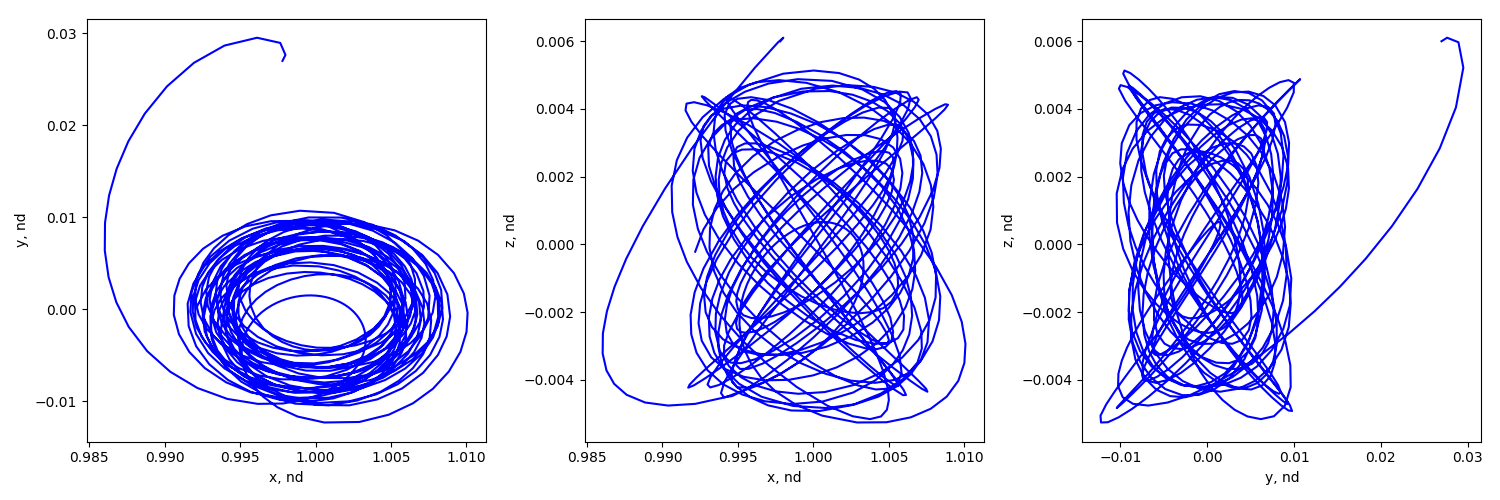

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd28999c2e8>,
      dtype=object)

In [332]:
plotter.plot_proj(df.iloc[400:])

In [351]:
det = op.event_detector(model, events=[cx])

In [352]:
ddf, dev = det.prop(s1, 0.0, 90)

TypeError: only size-1 arrays can be converted to Python scalars

In [335]:
dev

,e,cnt,trm,t,x,y,z,vx,vy,vz
0,0.0,-1.0,1.0,6.898065,0.988578,-6.071532e-18,0.00244,0.004895,0.025721,0.008031


<IPython.core.display.Javascript object>


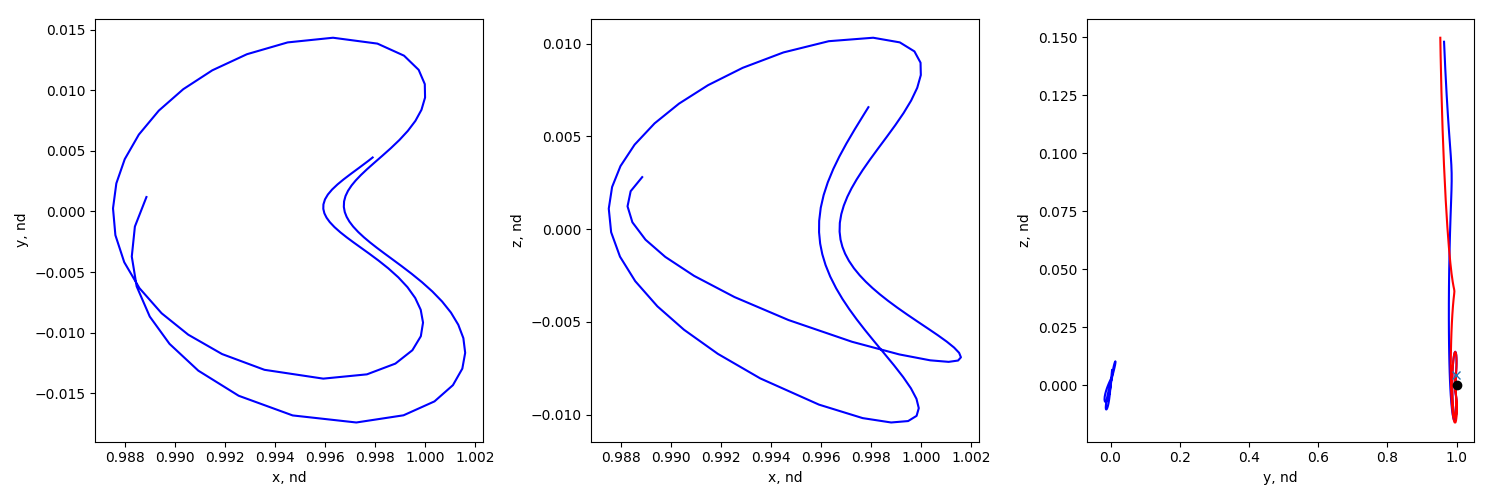

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2897de208>,
      dtype=object)

In [336]:
plotter.plot_proj(ddf)

In [239]:
hyp = Hyperbolic()

In [240]:
p1_upper = [hyp.p1_table(orb) for orb in traj_upper]
p1_lower = [hyp.p1_table(orb) for orb in traj_lower]

p2_upper = [hyp.p2_table(orb) for orb in traj_upper]
p2_lower = [hyp.p2_table(orb) for orb in traj_lower]

<IPython.core.display.Javascript object>


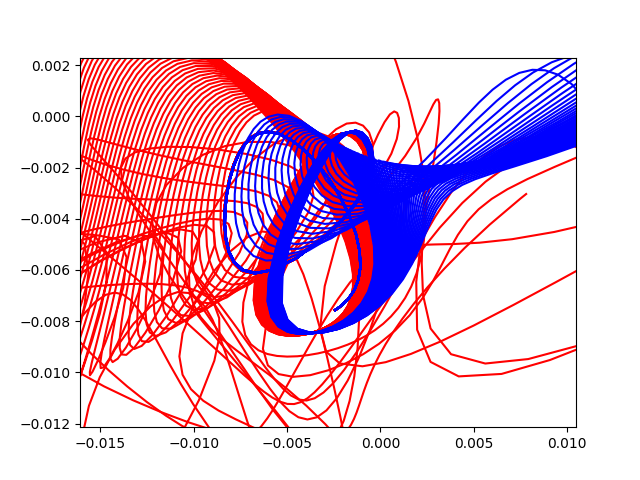

In [252]:
for p1_traj, p2_traj in zip(p1_upper, p2_upper):
    plt.plot(p1_traj, p2_traj, 'r')
    
for p1_traj, p2_traj in zip(p1_lower, p2_lower):
    plt.plot(p1_traj, p2_traj, 'b')
    
# plt.plot(p1_upper[0], p2_upper[0], 'k')
# plt.plot(p1_lower[-1], p2_lower[-1], 'g')

<IPython.core.display.Javascript object>


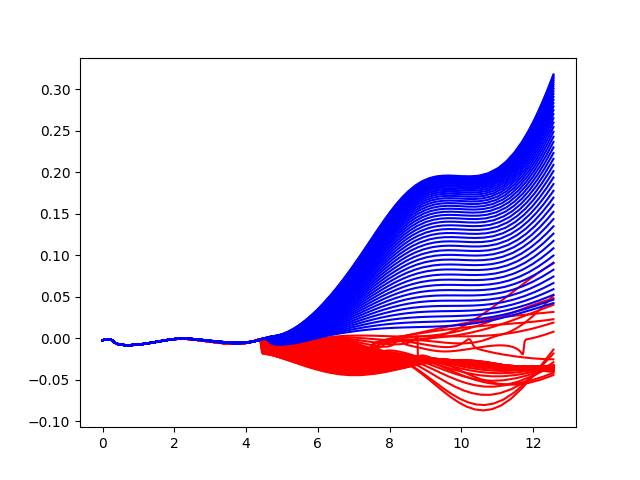

In [237]:
for i, p1_traj in enumerate(p1_upper):
    plt.plot(traj_upper[i]['t'], p1_traj,'r')

for i, p1_traj in enumerate(p1_lower):
    plt.plot(traj_lower[i]['t'], p1_traj,'b')